### Задание 3. Python

In [1]:
# импортируем нужные библиотеки

import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest
import matplotlib.pyplot as plt

#### Функция для автоматической подгрузки информации из дополнительного файла и пересчета метрик: 

In [2]:
def update_and_recalculate_metrics(
    groups_add_path='Проект_2_group_add.csv',
    groups_path='Проект_2_groups.csv',
    active_studs_path='Проект_2_active_studs.csv',
    checks_path='Проект_2_checks.csv',
):
    # Загрузка основного файла groups
    groups = pd.read_csv(groups_path, sep=';')
    groups = groups.rename(columns={groups.columns[0]: 'student_id', groups.columns[1]: 'group'})

    # Загрузка дополнительного файла groups_add 
    groups_add = pd.read_csv(groups_add_path)
    groups_add.columns = ['student_id', 'group']  # Автоматическое переименование, независимо от исходных заголовков

    # Загрузка active_studs
    active_studs = pd.read_csv(active_studs_path)

    # Загрузка checks
    checks = pd.read_csv(checks_path, sep=';')
    checks = checks.rename(columns={checks.columns[1]: 'revenue'})

    # Агрегация checks и active_studs
    checks_agg = checks.groupby('student_id').agg(revenue=('revenue', 'sum'), orders=('revenue', 'count')).reset_index()
    active_studs_agg = active_studs.groupby('student_id').agg(active_days=('student_id', 'count')).reset_index()

    # Объединение основного groups с дополнительным groups_add
    all_groups = pd.concat([groups, groups_add], ignore_index=True)

    # Объединение всех данных
    df = all_groups.merge(checks_agg, on='student_id', how='left') \
                    .merge(active_studs_agg, on='student_id', how='left')
    df = df.fillna({'orders': 0, 'revenue': 0.0, 'active_days': 0})

    # Рассчет метрик
    metrics = df.groupby('group').agg(
        users_count=('student_id', 'count'),
        buyers=('orders', lambda x: (x > 0).sum()),
        orders=('orders', 'sum'),
        revenue=('revenue', 'sum')
    ).reset_index()
    
    metrics['conversion'] = metrics['buyers'] / metrics['users_count']
    metrics['arpu'] = metrics['revenue'] / metrics['users_count']
    metrics['aov'] = metrics['revenue'] / metrics['buyers']

    # Разделение на группы
    groupA = df[df['group'] == 'A']
    groupB = df[df['group'] == 'B']

    # Конверсия и z-test
    conv_a = (groupA['orders'] > 0).sum()
    conv_b = (groupB['orders'] > 0).sum()
    n_a = groupA.shape[0]
    n_b = groupB.shape[0]
    z_stat, pval_conv = proportions_ztest([conv_a, conv_b], [n_a, n_b])

    # ARPU и bootstrap
    def bootstrap_diff_mean(x, y, n_boot=5000, seed=42):
        rng = np.random.RandomState(seed)
        diffs = []
        for _ in range(n_boot):
            xs = rng.choice(x, len(x), replace=True)
            ys = rng.choice(y, len(y), replace=True)
            diffs.append(ys.mean() - xs.mean())
        return np.percentile(diffs, [2.5, 97.5]), np.mean(diffs)

    ci_arpu, diff_mean_arpu = bootstrap_diff_mean(groupA['revenue'], groupB['revenue'])

    # AOV с критерием Манна-Уитни
    buyers_a = groupA[groupA['orders'] > 0]['revenue']
    buyers_b = groupB[groupB['orders'] > 0]['revenue']
    u_stat, pval_aov = stats.mannwhitneyu(buyers_a, buyers_b, alternative='two-sided')

    # Сбор результатов в DataFrame
    results = pd.DataFrame({
        'metric': ['conversion', 'arpu', 'aov'],
        'group_A': [conv_a / n_a, groupA['revenue'].mean(), buyers_a.mean()],
        'group_B': [conv_b / n_b, groupB['revenue'].mean(), buyers_b.mean()],
        'p_value': [pval_conv, None, pval_aov],  
        'ci_lower': [None, ci_arpu[0], None],
        'ci_upper': [None, ci_arpu[1], None],
        'diff_mean': [None, diff_mean_arpu, None]
    })

    return results, df  # Возвращаем метрики и обновленный датафрейм

#### Функция для построения графиков по получаемым метрикам:

In [3]:
def plot_metrics(metrics_df, df, plot_types=['box', 'hist']): # metrics_df - датафрейм с метриками из предыдущей функции
    groupA = df[df['group'] == 'A']
    groupB = df[df['group'] == 'B']

    if 'box' in plot_types:
        plt.figure(figsize=(12, 8))
        plt.boxplot([groupA['revenue'], groupB['revenue']], labels=['A', 'B'])
        plt.title('Revenue per User by Group')
        plt.show()

    if 'hist' in plot_types:
        plt.figure(figsize=(12, 8))
        plt.hist([groupA['revenue'], groupB['revenue']], bins=100, label=['A', 'B'], alpha=0.6)
        plt.legend()
        plt.title('Revenue Distribution')
        plt.show()

#### Пример использования функций:

In [4]:
metrics, updated_df = update_and_recalculate_metrics()

In [5]:
metrics

,metric,group_A,group_B,p_value,ci_lower,ci_upper,diff_mean
0,conversion,0.007282,0.007247,0.964357,NaN,NaN,NaN
1,arpu,6.268019,8.036171,NaN,-0.150574,3.573081,1.771101
2,aov,860.710280,1108.824893,0.000193,NaN,NaN,NaN


/opt/tljh/user/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


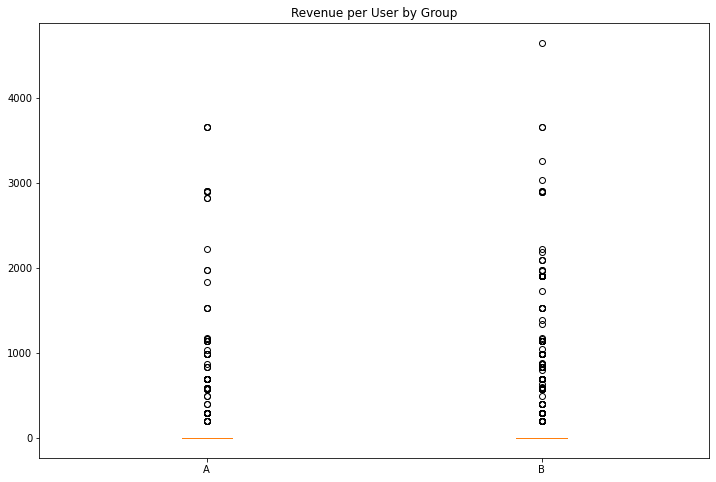

/opt/tljh/user/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/opt/tljh/user/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


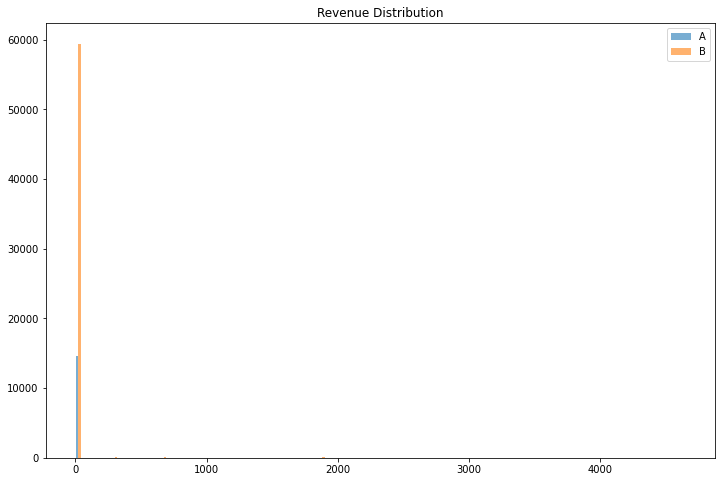

In [11]:
plot_metrics(metrics, updated_df)